<a href="https://colab.research.google.com/github/dslmllab/dSL-Lab-Coding-Challenge/blob/main/1_text_preprocessing_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Preprocessing Fundamentals for NLP

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Master text cleaning techniques** for real-world data
2. **Implement tokenization strategies** for different languages
3. **Apply normalization methods** including stemming and lemmatization
4. **Handle special text formats** (emails, URLs, social media)
5. **Build robust preprocessing pipelines** for various NLP tasks
6. **Understand encoding and unicode issues** in text processing
7. **Create custom preprocessing functions** for domain-specific text

## Introduction

Text preprocessing is the foundation of any successful NLP project. Raw text data is often messy, inconsistent, and contains various artifacts that can hinder model performance. This notebook covers comprehensive text preprocessing techniques from basic to advanced.

### Why Preprocessing Matters:
- **Noise Reduction**: Remove irrelevant characters and formatting
- **Standardization**: Ensure consistent text format
- **Feature Engineering**: Transform text into meaningful features
- **Performance**: Improve model accuracy and training efficiency

## 1. Setup and Imports

In [3]:
!pip3 install numpy pandas matplotlib seaborn nltk spacy scikit-learn tqdm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [15]:

# Download spaCy English model if not present
import spacy
try:
    spacy.load("en_core_web_sm")
except OSError:
    !python3 -m spacy download en_core_web_sm

/Users/expansionislife/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.8 MB 2.1 MB/s eta 0:00:01     |████████████████████████████▌   | 11.4 MB 2.3 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [16]:
import re
import string
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag

# Download required NLTK data
nltk_downloads = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger', 'maxent_ne_chunker', 'words','punkt_tab','averaged_perceptron_tagger_eng']
for item in nltk_downloads:
    try:
        nltk.download(item, quiet=True)
    except:
        print(f"Could not download {item}")

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("spaCy English model not found. Install with: python -m spacy download en_core_web_sm")
    nlp = None

plt.style.use('default')
%matplotlib inline

print("Setup completed successfully!")

Setup completed successfully!


## 2. Sample Text Data

In [17]:
# Create diverse sample texts for preprocessing
sample_texts = {
    'social_media': [
        "OMG!!! This is AMAZING 😍😍😍 #bestday #excited @john_doe https://example.com/photo",
        "Can't believe it's already 2023... time flies so fast! 🕐 RT if you agree 👍",
        "Working from home again 😴 Coffee ☕ is my best friend today #WFH #Monday"
    ],
    'emails': [
        "Dear Mr. Smith,\n\nI hope this email finds you well. I am writing to discuss...",
        "Hi there!\n\nThanks for your email. Please find attached the document you requested.",
        "Subject: Re: Meeting Tomorrow\n\nHi team,\n\nLet's reschedule to 3 PM EST."
    ],
    'news': [
        "Breaking: The stock market reached an all-time high today, with tech stocks leading the surge.",
        "Scientists discover new species in the Amazon rainforest, highlighting biodiversity importance.",
        "Local weather update: Expect thunderstorms this afternoon with temperatures around 75°F."
    ],
    'reviews': [
        "This product is absolutely terrible!!! Don't waste your money. 1/5 stars ⭐",
        "Pretty good overall, but could be better. The delivery was fast though. 4/5",
        "BEST PURCHASE EVER! Highly recommend to everyone!!! 5 stars ⭐⭐⭐⭐⭐"
    ],
    'technical': [
        "The API endpoint returns JSON data with user_id, timestamp, and status_code fields.",
        "To install the package, run: pip install numpy==1.21.0 --user",
        "Error 404: Page not found. Check the URL: https://api.example.com/v1/users"
    ]
}

# Combine all texts for analysis
all_texts = []
text_labels = []
for category, texts in sample_texts.items():
    all_texts.extend(texts)
    text_labels.extend([category] * len(texts))

# Create DataFrame
df = pd.DataFrame({
    'text': all_texts,
    'category': text_labels
})

print(f"Created dataset with {len(df)} text samples across {len(sample_texts)} categories")
print("\nCategory distribution:")
print(df['category'].value_counts())

# Display sample texts
print("\nSample texts:")
for i, row in df.head().iterrows():
    print(f"{row['category']}: {row['text'][:80]}...")

Created dataset with 15 text samples across 5 categories

Category distribution:
category
social_media    3
emails          3
news            3
reviews         3
technical       3
Name: count, dtype: int64

Sample texts:
social_media: OMG!!! This is AMAZING 😍😍😍 #bestday #excited @john_doe https://example.com/photo...
social_media: Can't believe it's already 2023... time flies so fast! 🕐 RT if you agree 👍...
social_media: Working from home again 😴 Coffee ☕ is my best friend today #WFH #Monday...
emails: Dear Mr. Smith,

I hope this email finds you well. I am writing to discuss......
emails: Hi there!

Thanks for your email. Please find attached the document you requeste...


## 3. Basic Text Cleaning

In [20]:
class BasicTextCleaner:
    """Basic text cleaning operations"""

    def __init__(self):
        self.url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
        self.mention_pattern = re.compile(r'@\w+')
        self.hashtag_pattern = re.compile(r'#\w+')
        self.phone_pattern = re.compile(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b')

    def remove_urls(self, text):
        """Remove URLs from text"""
        return self.url_pattern.sub('', text)

    def remove_emails(self, text):
        """Remove email addresses from text"""
        return self.email_pattern.sub('', text)

    def remove_mentions(self, text):
        """Remove social media mentions (@username)"""
        return self.mention_pattern.sub('', text)

    def remove_hashtags(self, text):
        """Remove hashtags from text"""
        return self.hashtag_pattern.sub('', text)

    def remove_phone_numbers(self, text):
        """Remove phone numbers from text"""
        return self.phone_pattern.sub('', text)

    def remove_extra_whitespace(self, text):
        """Remove extra whitespace and normalize"""
        # Replace multiple whitespace with single space
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def remove_special_characters(self, text, keep_alphanumeric=True):
        """Remove special characters"""
        if keep_alphanumeric:
            # Keep letters, numbers, and spaces
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        else:
            # Keep only letters and spaces
            text = re.sub(r'[^a-zA-Z\s]', '', text)
        return text

    def to_lowercase(self, text):
        """Convert text to lowercase"""
        return text.lower()

    def basic_clean(self, text):
        """Apply basic cleaning pipeline"""
        text = self.remove_urls(text)
        text = self.remove_emails(text)
        text = self.remove_extra_whitespace(text)
        text = self.to_lowercase(text)
        return text

# Test basic cleaning
cleaner = BasicTextCleaner()

print("Basic Text Cleaning Examples:")
print("=" * 50)

for category, texts in sample_texts.items():
    print(f"\n{category.upper()}:")
    for text in texts[:1]:  # Show first example from each category
        print(f"Original: {text}")
        cleaned = cleaner.basic_clean(text)
        print(f"Cleaned:  {cleaned}")
        print("-" * 40)

Basic Text Cleaning Examples:

SOCIAL_MEDIA:
Original: OMG!!! This is AMAZING 😍😍😍 #bestday #excited @john_doe https://example.com/photo
Cleaned:  omg!!! this is amazing 😍😍😍 #bestday #excited @john_doe
----------------------------------------

EMAILS:
Original: Dear Mr. Smith,

I hope this email finds you well. I am writing to discuss...
Cleaned:  dear mr. smith, i hope this email finds you well. i am writing to discuss...
----------------------------------------

NEWS:
Original: Breaking: The stock market reached an all-time high today, with tech stocks leading the surge.
Cleaned:  breaking: the stock market reached an all-time high today, with tech stocks leading the surge.
----------------------------------------

REVIEWS:
Original: This product is absolutely terrible!!! Don't waste your money. 1/5 stars ⭐
Cleaned:  this product is absolutely terrible!!! don't waste your money. 1/5 stars ⭐
----------------------------------------

TECHNICAL:
Original: The API endpoint returns JSON da

## 4. Advanced Text Cleaning

In [23]:
class AdvancedTextCleaner(BasicTextCleaner):
    """Advanced text cleaning with Unicode and encoding handling"""

    def __init__(self):
        super().__init__()
        self.emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE
        )

    def normalize_unicode(self, text):
        """Normalize Unicode characters"""
        # Normalize to NFKD form (canonical decomposition)
        text = unicodedata.normalize('NFKD', text)
        # Remove combining characters
        text = ''.join(c for c in text if not unicodedata.combining(c))
        return text

    def remove_emojis(self, text):
        """Remove emoji characters"""
        return self.emoji_pattern.sub('', text)

    def expand_contractions(self, text):
        """Expand common English contractions"""
        contractions = {
            "can't": "cannot",
            "won't": "will not",
            "n't": " not",
            "'re": " are",
            "'ve": " have",
            "'ll": " will",
            "'d": " would",
            "'m": " am",
            "'s": " is"
        }

        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)

        return text

    def handle_repetitions(self, text, max_repeat=2):
        """Handle character repetitions (e.g., 'sooo' -> 'so')"""
        pattern = r'(.)\1{' + str(max_repeat) + ',}'
        return re.sub(pattern, r'\1' * max_repeat, text)

    def remove_html_tags(self, text):
        """Remove HTML tags from text"""
        html_pattern = re.compile(r'<.*?>')
        return html_pattern.sub('', text)

    def normalize_numbers(self, text, replace_with='<NUM>'):
        """Replace numbers with placeholder"""
        # Match integers and floats
        number_pattern = r'\b\d+(?:\.\d+)?\b'
        return re.sub(number_pattern, replace_with, text)

    def advanced_clean(self, text):
        """Apply advanced cleaning pipeline"""
        text = self.normalize_unicode(text)
        text = self.remove_html_tags(text)
        text = self.expand_contractions(text)
        text = self.remove_emojis(text)
        text = self.remove_urls(text)
        text = self.remove_emails(text)
        text = self.remove_mentions(text)
        text = self.remove_hashtags(text)
        text = self.handle_repetitions(text)
        text = self.remove_extra_whitespace(text)
        text = self.to_lowercase(text)
        return text

# Test advanced cleaning
advanced_cleaner = AdvancedTextCleaner()

print("Advanced Text Cleaning Examples:")
print("=" * 50)

test_texts = [
    "OMG!!! This is AMAZING 😍😍😍 #bestday can't believe it!!!",
    "Check this out: https://example.com @john_doe 🔥🔥",
    "I'm sooooo excited!!! Won't you join us? 💯",
    "<p>HTML content with <strong>tags</strong></p>",
    "Numbers: 123, 45.67, and $89.99 are here"
]

for text in test_texts:
    print(f"Original: {text}")
    cleaned = advanced_cleaner.advanced_clean(text)
    print(f"Cleaned:  {cleaned}")
    print("-" * 40)

Advanced Text Cleaning Examples:
Original: OMG!!! This is AMAZING 😍😍😍 #bestday can't believe it!!!
Cleaned:  omg!! this is amazing cannot believe it!!
----------------------------------------
Original: Check this out: https://example.com @john_doe 🔥🔥
Cleaned:  check this out:
----------------------------------------
Original: I'm sooooo excited!!! Won't you join us? 💯
Cleaned:  i am soo excited!! wo not you join us?
----------------------------------------
Original: <p>HTML content with <strong>tags</strong></p>
Cleaned:  html content with tags
----------------------------------------
Original: Numbers: 123, 45.67, and $89.99 are here
Cleaned:  numbers: 123, 45.67, and $89.99 are here
----------------------------------------


## 5. Tokenization Strategies

In [9]:
class TokenizationTools:
    """Various tokenization strategies"""

    def __init__(self):
        pass

    def simple_tokenize(self, text):
        """Simple whitespace tokenization"""
        return text.split()

    def nltk_word_tokenize(self, text):
        """NLTK word tokenization"""
        return word_tokenize(text)

    def regex_tokenize(self, text, pattern=r'\b\w+\b'):
        """Regex-based tokenization"""
        return re.findall(pattern, text)

    def sentence_tokenize(self, text):
        """Sentence tokenization"""
        return sent_tokenize(text)

    def spacy_tokenize(self, text):
        """spaCy tokenization"""
        if nlp is None:
            return self.nltk_word_tokenize(text)
        doc = nlp(text)
        return [token.text for token in doc]

    def custom_tokenize(self, text, preserve_case=False, min_length=1):
        """Custom tokenization with options"""
        # Split on whitespace and punctuation
        tokens = re.findall(r'\b\w+\b', text)

        if not preserve_case:
            tokens = [token.lower() for token in tokens]

        # Filter by minimum length
        tokens = [token for token in tokens if len(token) >= min_length]

        return tokens

    def subword_tokenize(self, text, max_subword_length=6):
        """Simple subword tokenization (character n-grams)"""
        words = self.simple_tokenize(text)
        subwords = []

        for word in words:
            if len(word) <= max_subword_length:
                subwords.append(word)
            else:
                # Split into overlapping subwords
                for i in range(len(word) - max_subword_length + 1):
                    subwords.append(word[i:i + max_subword_length])

        return subwords

    def compare_tokenizers(self, text):
        """Compare different tokenization methods"""
        methods = {
            'Simple': self.simple_tokenize,
            'NLTK': self.nltk_word_tokenize,
            'Regex': self.regex_tokenize,
            'spaCy': self.spacy_tokenize,
            'Custom': self.custom_tokenize
        }

        results = {}
        for name, method in methods.items():
            try:
                tokens = method(text)
                results[name] = tokens
            except Exception as e:
                results[name] = f"Error: {e}"

        return results

# Test tokenization
tokenizer = TokenizationTools()

test_text = "Hello, world! This is a test sentence with punctuation... How does it work?"

print("Tokenization Comparison:")
print("=" * 50)
print(f"Text: {test_text}")
print()

results = tokenizer.compare_tokenizers(test_text)
for method, tokens in results.items():
    if isinstance(tokens, list):
        print(f"{method:8}: {tokens} ({len(tokens)} tokens)")
    else:
        print(f"{method:8}: {tokens}")

# Test sentence tokenization
long_text = "Hello world. This is the first sentence! Is this the second? Yes, it is."
sentences = tokenizer.sentence_tokenize(long_text)
print(f"\nSentence tokenization:")
for i, sent in enumerate(sentences, 1):
    print(f"{i}. {sent}")

Tokenization Comparison:
Text: Hello, world! This is a test sentence with punctuation... How does it work?

Simple  : ['Hello,', 'world!', 'This', 'is', 'a', 'test', 'sentence', 'with', 'punctuation...', 'How', 'does', 'it', 'work?'] (13 tokens)
NLTK    : ['Hello', ',', 'world', '!', 'This', 'is', 'a', 'test', 'sentence', 'with', 'punctuation', '...', 'How', 'does', 'it', 'work', '?'] (17 tokens)
Regex   : ['Hello', 'world', 'This', 'is', 'a', 'test', 'sentence', 'with', 'punctuation', 'How', 'does', 'it', 'work'] (13 tokens)
spaCy   : ['Hello', ',', 'world', '!', 'This', 'is', 'a', 'test', 'sentence', 'with', 'punctuation', '...', 'How', 'does', 'it', 'work', '?'] (17 tokens)
Custom  : ['hello', 'world', 'this', 'is', 'a', 'test', 'sentence', 'with', 'punctuation', 'how', 'does', 'it', 'work'] (13 tokens)

Sentence tokenization:
1. Hello world.
2. This is the first sentence!
3. Is this the second?
4. Yes, it is.


## 6. Text Normalization

In [24]:
class TextNormalizer:
    """Text normalization including stemming and lemmatization"""

    def __init__(self):
        self.porter_stemmer = PorterStemmer()
        self.snowball_stemmer = SnowballStemmer('english')
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def stem_porter(self, tokens):
        """Apply Porter stemming"""
        return [self.porter_stemmer.stem(token) for token in tokens]

    def stem_snowball(self, tokens):
        """Apply Snowball stemming"""
        return [self.snowball_stemmer.stem(token) for token in tokens]

    def lemmatize(self, tokens, pos_tags=None):
        """Apply lemmatization with optional POS tags"""
        if pos_tags is None:
            return [self.lemmatizer.lemmatize(token) for token in tokens]
        else:
            lemmatized = []
            for token, pos in zip(tokens, pos_tags):
                # Convert POS tag to WordNet format
                wordnet_pos = self._get_wordnet_pos(pos)
                lemmatized.append(self.lemmatizer.lemmatize(token, wordnet_pos))
            return lemmatized

    def _get_wordnet_pos(self, pos_tag):
        """Convert NLTK POS tag to WordNet POS tag"""
        if pos_tag.startswith('J'):
            return 'a'  # adjective
        elif pos_tag.startswith('V'):
            return 'v'  # verb
        elif pos_tag.startswith('N'):
            return 'n'  # noun
        elif pos_tag.startswith('R'):
            return 'r'  # adverb
        else:
            return 'n'  # default to noun

    def remove_stopwords(self, tokens, custom_stopwords=None):
        """Remove stopwords"""
        stopwords_set = self.stop_words
        if custom_stopwords:
            stopwords_set = stopwords_set.union(set(custom_stopwords))

        return [token for token in tokens if token.lower() not in stopwords_set]

    def normalize_tokens(self, tokens, method='lemma', remove_stops=True, pos_tags=None):
        """Normalize tokens using specified method"""
        # Remove stopwords first if requested
        if remove_stops:
            tokens = self.remove_stopwords(tokens)

        # Apply normalization method
        if method == 'porter':
            return self.stem_porter(tokens)
        elif method == 'snowball':
            return self.stem_snowball(tokens)
        elif method == 'lemma':
            return self.lemmatize(tokens, pos_tags)
        else:
            return tokens

    def compare_normalization(self, text):
        """Compare different normalization methods"""
        # Tokenize text
        tokens = word_tokenize(text.lower())

        # Get POS tags for better lemmatization
        pos_tags = [tag for word, tag in pos_tag(tokens)]

        results = {
            'Original': tokens,
            'Porter Stem': self.stem_porter(tokens),
            'Snowball Stem': self.stem_snowball(tokens),
            'Lemmatized': self.lemmatize(tokens, pos_tags),
            'No Stopwords': self.remove_stopwords(tokens)
        }

        return results

# Test normalization
normalizer = TextNormalizer()

test_text = "The cats were running and jumping over the fences quickly."

print("Text Normalization Comparison:")
print("=" * 50)
print(f"Text: {test_text}")
print()

results = normalizer.compare_normalization(test_text)
for method, tokens in results.items():
    print(f"{method:15}: {tokens}")

# Test with more complex examples
complex_examples = [
    "The children were happily playing with their toys.",
    "He has been studying and learning new techniques.",
    "The best restaurants are serving delicious meals."
]

print("\n" + "=" * 60)
print("STEMMING vs LEMMATIZATION COMPARISON")
print("=" * 60)

for text in complex_examples:
    tokens = word_tokenize(text.lower())
    # Remove non-alphabetic tokens
    tokens = [t for t in tokens if t.isalpha()]

    pos_tags = [tag for word, tag in pos_tag(tokens)]

    print(f"\nOriginal:  {' '.join(tokens)}")
    print(f"Porter:    {' '.join(normalizer.stem_porter(tokens))}")
    print(f"Snowball:  {' '.join(normalizer.stem_snowball(tokens))}")
    print(f"Lemmatized: {' '.join(normalizer.lemmatize(tokens, pos_tags))}")

Text Normalization Comparison:
Text: The cats were running and jumping over the fences quickly.

Original       : ['the', 'cats', 'were', 'running', 'and', 'jumping', 'over', 'the', 'fences', 'quickly', '.']
Porter Stem    : ['the', 'cat', 'were', 'run', 'and', 'jump', 'over', 'the', 'fenc', 'quickli', '.']
Snowball Stem  : ['the', 'cat', 'were', 'run', 'and', 'jump', 'over', 'the', 'fenc', 'quick', '.']
Lemmatized     : ['the', 'cat', 'be', 'run', 'and', 'jumping', 'over', 'the', 'fence', 'quickly', '.']
No Stopwords   : ['cats', 'running', 'jumping', 'fences', 'quickly', '.']

STEMMING vs LEMMATIZATION COMPARISON

Original:  the children were happily playing with their toys
Porter:    the children were happili play with their toy
Snowball:  the children were happili play with their toy
Lemmatized: the child be happily play with their toy

Original:  he has been studying and learning new techniques
Porter:    he ha been studi and learn new techniqu
Snowball:  he has been studi and lea

## 7. Comprehensive Preprocessing Pipeline

In [11]:
class TextPreprocessingPipeline:
    """Complete text preprocessing pipeline"""

    def __init__(self, config=None):
        self.cleaner = AdvancedTextCleaner()
        self.tokenizer = TokenizationTools()
        self.normalizer = TextNormalizer()

        # Default configuration
        self.config = {
            'lowercase': True,
            'remove_urls': True,
            'remove_emails': True,
            'remove_mentions': True,
            'remove_hashtags': True,
            'remove_emojis': True,
            'expand_contractions': True,
            'remove_html': True,
            'normalize_unicode': True,
            'handle_repetitions': True,
            'tokenization_method': 'nltk',  # 'simple', 'nltk', 'spacy', 'custom'
            'normalization_method': 'lemma',  # 'none', 'porter', 'snowball', 'lemma'
            'remove_stopwords': True,
            'min_token_length': 2,
            'max_token_length': 50,
            'remove_digits': False,
            'remove_punctuation': True
        }

        if config:
            self.config.update(config)

    def clean_text(self, text):
        """Apply text cleaning based on configuration"""
        if self.config['normalize_unicode']:
            text = self.cleaner.normalize_unicode(text)

        if self.config['remove_html']:
            text = self.cleaner.remove_html_tags(text)

        if self.config['expand_contractions']:
            text = self.cleaner.expand_contractions(text)

        if self.config['remove_emojis']:
            text = self.cleaner.remove_emojis(text)

        if self.config['remove_urls']:
            text = self.cleaner.remove_urls(text)

        if self.config['remove_emails']:
            text = self.cleaner.remove_emails(text)

        if self.config['remove_mentions']:
            text = self.cleaner.remove_mentions(text)

        if self.config['remove_hashtags']:
            text = self.cleaner.remove_hashtags(text)

        if self.config['handle_repetitions']:
            text = self.cleaner.handle_repetitions(text)

        if self.config['lowercase']:
            text = text.lower()

        text = self.cleaner.remove_extra_whitespace(text)

        return text

    def tokenize_text(self, text):
        """Tokenize text based on configuration"""
        method = self.config['tokenization_method']

        if method == 'simple':
            tokens = self.tokenizer.simple_tokenize(text)
        elif method == 'nltk':
            tokens = self.tokenizer.nltk_word_tokenize(text)
        elif method == 'spacy':
            tokens = self.tokenizer.spacy_tokenize(text)
        elif method == 'custom':
            tokens = self.tokenizer.custom_tokenize(text)
        else:
            tokens = self.tokenizer.nltk_word_tokenize(text)

        return tokens

    def filter_tokens(self, tokens):
        """Filter tokens based on configuration"""
        filtered_tokens = []

        for token in tokens:
            # Skip empty tokens
            if not token.strip():
                continue

            # Length filtering
            if len(token) < self.config['min_token_length']:
                continue
            if len(token) > self.config['max_token_length']:
                continue

            # Remove digits if configured
            if self.config['remove_digits'] and token.isdigit():
                continue

            # Remove punctuation if configured
            if self.config['remove_punctuation'] and token in string.punctuation:
                continue

            # Remove non-alphabetic tokens if strict
            if not token.isalpha() and self.config.get('alphabetic_only', False):
                continue

            filtered_tokens.append(token)

        return filtered_tokens

    def normalize_tokens(self, tokens):
        """Normalize tokens based on configuration"""
        method = self.config['normalization_method']
        remove_stops = self.config['remove_stopwords']

        # Get POS tags if using lemmatization
        pos_tags = None
        if method == 'lemma':
            pos_tags = [tag for word, tag in pos_tag(tokens)]

        return self.normalizer.normalize_tokens(tokens, method, remove_stops, pos_tags)

    def preprocess(self, text):
        """Complete preprocessing pipeline"""
        # Clean text
        cleaned_text = self.clean_text(text)

        # Tokenize
        tokens = self.tokenize_text(cleaned_text)

        # Filter tokens
        filtered_tokens = self.filter_tokens(tokens)

        # Normalize tokens
        if self.config['normalization_method'] != 'none':
            normalized_tokens = self.normalize_tokens(filtered_tokens)
        else:
            normalized_tokens = filtered_tokens

        return normalized_tokens

    def preprocess_batch(self, texts):
        """Preprocess a batch of texts"""
        return [self.preprocess(text) for text in texts]

    def get_stats(self, original_texts, processed_tokens):
        """Get preprocessing statistics"""
        stats = {
            'total_texts': len(original_texts),
            'avg_original_length': np.mean([len(text) for text in original_texts]),
            'avg_tokens_per_text': np.mean([len(tokens) for tokens in processed_tokens]),
            'total_tokens': sum(len(tokens) for tokens in processed_tokens),
            'unique_tokens': len(set(token for tokens in processed_tokens for token in tokens))
        }
        return stats

# Test the complete pipeline
print("Complete Preprocessing Pipeline Test:")
print("=" * 50)

# Test with different configurations
configs = {
    'basic': {
        'normalization_method': 'none',
        'remove_stopwords': False
    },
    'standard': {
        'normalization_method': 'lemma',
        'remove_stopwords': True
    },
    'aggressive': {
        'normalization_method': 'porter',
        'remove_stopwords': True,
        'min_token_length': 3,
        'alphabetic_only': True
    }
}

test_text = "OMG!!! I can't believe this is happening 😍 Check out https://example.com @username #amazing"

for config_name, config in configs.items():
    pipeline = TextPreprocessingPipeline(config)
    result = pipeline.preprocess(test_text)

    print(f"\n{config_name.upper()} CONFIG:")
    print(f"Original: {test_text}")
    print(f"Result:   {result}")
    print(f"Tokens:   {len(result)}")

# Test with all sample texts
standard_pipeline = TextPreprocessingPipeline()
all_processed = standard_pipeline.preprocess_batch(all_texts)
stats = standard_pipeline.get_stats(all_texts, all_processed)

print("\n" + "=" * 50)
print("BATCH PROCESSING STATISTICS")
print("=" * 50)
for key, value in stats.items():
    print(f"{key:20}: {value:.2f}" if isinstance(value, float) else f"{key:20}: {value}")

Complete Preprocessing Pipeline Test:

BASIC CONFIG:
Original: OMG!!! I can't believe this is happening 😍 Check out https://example.com @username #amazing
Result:   ['omg', 'can', 'not', 'believe', 'this', 'is', 'happening', 'check', 'out']
Tokens:   9

STANDARD CONFIG:
Original: OMG!!! I can't believe this is happening 😍 Check out https://example.com @username #amazing
Result:   ['omg', 'believe', 'happening', 'check']
Tokens:   4

AGGRESSIVE CONFIG:
Original: OMG!!! I can't believe this is happening 😍 Check out https://example.com @username #amazing
Result:   ['omg', 'believ', 'happen', 'check']
Tokens:   4

BATCH PROCESSING STATISTICS
total_texts         : 15
avg_original_length : 77.53
avg_tokens_per_text : 8.00
total_tokens        : 120
unique_tokens       : 111


## 8. Preprocessing Analysis and Visualization

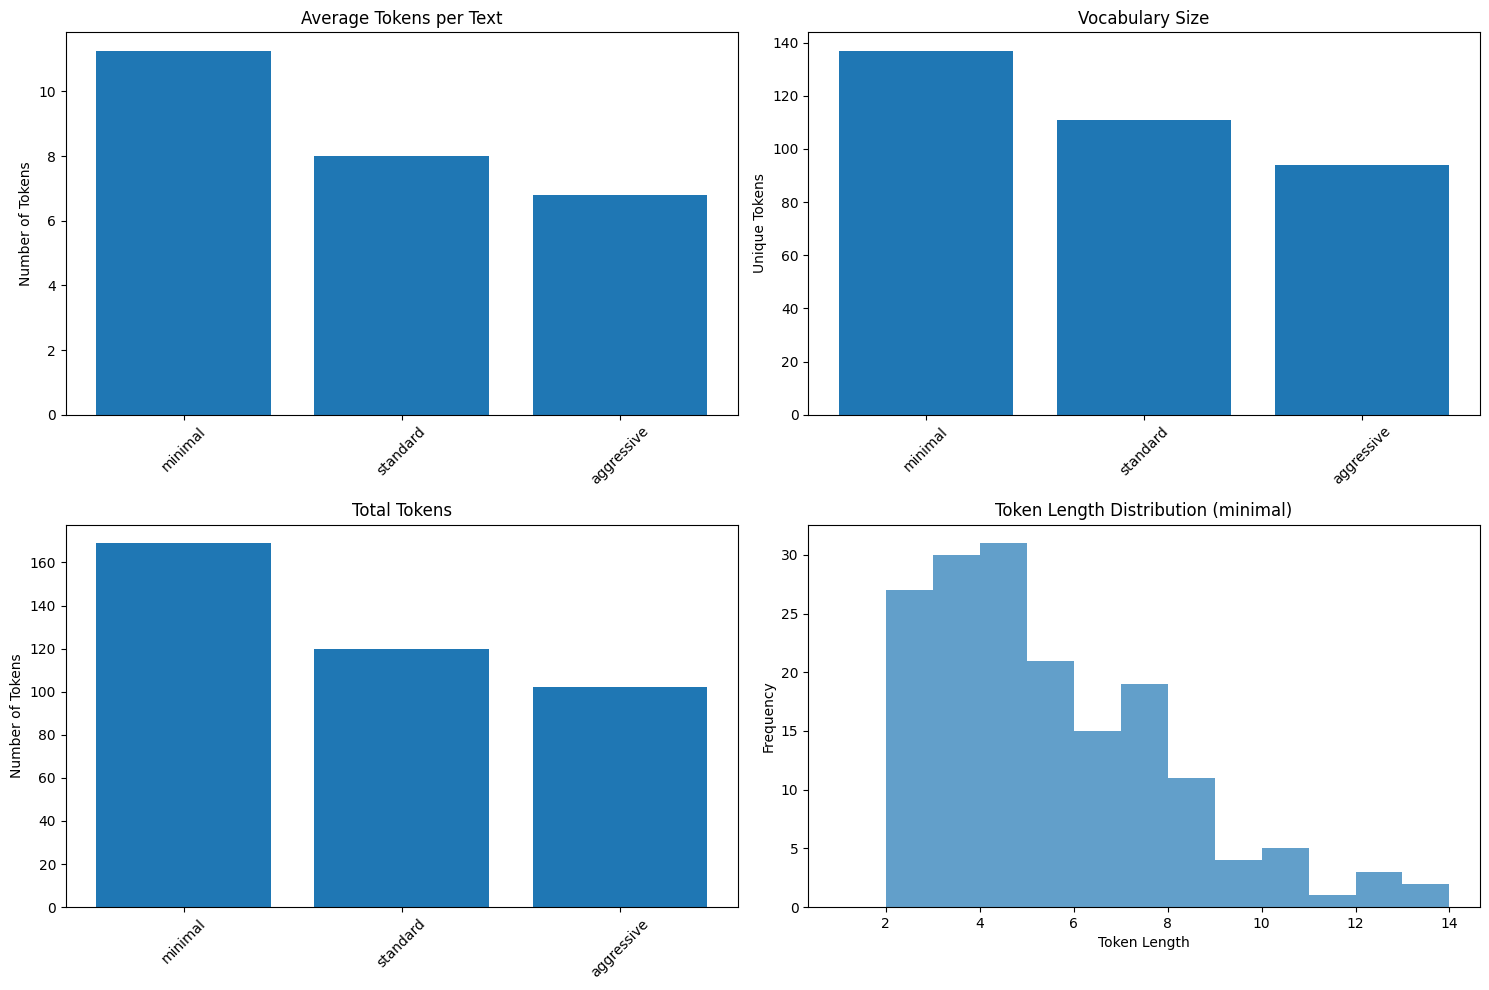


Detailed Preprocessing Comparison:

MINIMAL CONFIGURATION:
  Average tokens per text: 11.27
  Total tokens: 169
  Vocabulary size: 137
  Vocabulary/Total ratio: 0.811

STANDARD CONFIGURATION:
  Average tokens per text: 8.00
  Total tokens: 120
  Vocabulary size: 111
  Vocabulary/Total ratio: 0.925

AGGRESSIVE CONFIGURATION:
  Average tokens per text: 6.80
  Total tokens: 102
  Vocabulary size: 94
  Vocabulary/Total ratio: 0.922

SAMPLE PROCESSED TEXTS
Original: OMG!!! This is AMAZING 😍😍😍 #bestday #excited @john_doe https://example.com/photo
minimal   : omg this is amazing
standard  : omg amazing
aggressive: omg amaz


In [12]:
def analyze_preprocessing_impact(texts, pipeline_configs):
    """Analyze the impact of different preprocessing configurations"""
    results = {}

    for config_name, config in pipeline_configs.items():
        pipeline = TextPreprocessingPipeline(config)
        processed = pipeline.preprocess_batch(texts)
        stats = pipeline.get_stats(texts, processed)

        results[config_name] = {
            'processed_texts': processed,
            'stats': stats,
            'vocab': set(token for tokens in processed for token in tokens)
        }

    return results

def visualize_preprocessing_comparison(analysis_results):
    """Visualize preprocessing comparison"""
    configs = list(analysis_results.keys())

    # Extract metrics for comparison
    metrics = {
        'avg_tokens': [analysis_results[config]['stats']['avg_tokens_per_text'] for config in configs],
        'vocab_size': [len(analysis_results[config]['vocab']) for config in configs],
        'total_tokens': [analysis_results[config]['stats']['total_tokens'] for config in configs]
    }

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Average tokens per text
    axes[0, 0].bar(configs, metrics['avg_tokens'])
    axes[0, 0].set_title('Average Tokens per Text')
    axes[0, 0].set_ylabel('Number of Tokens')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # Vocabulary size
    axes[0, 1].bar(configs, metrics['vocab_size'])
    axes[0, 1].set_title('Vocabulary Size')
    axes[0, 1].set_ylabel('Unique Tokens')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # Total tokens
    axes[1, 0].bar(configs, metrics['total_tokens'])
    axes[1, 0].set_title('Total Tokens')
    axes[1, 0].set_ylabel('Number of Tokens')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Token length distribution for first config
    first_config = configs[0]
    all_tokens = [token for tokens in analysis_results[first_config]['processed_texts'] for token in tokens]
    token_lengths = [len(token) for token in all_tokens]

    axes[1, 1].hist(token_lengths, bins=range(1, max(token_lengths) + 2), alpha=0.7)
    axes[1, 1].set_title(f'Token Length Distribution ({first_config})')
    axes[1, 1].set_xlabel('Token Length')
    axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    return metrics

# Test preprocessing configurations
test_configs = {
    'minimal': {
        'lowercase': True,
        'normalization_method': 'none',
        'remove_stopwords': False,
        'remove_punctuation': False
    },
    'standard': {
        'normalization_method': 'lemma',
        'remove_stopwords': True
    },
    'aggressive': {
        'normalization_method': 'porter',
        'remove_stopwords': True,
        'min_token_length': 3,
        'alphabetic_only': True
    }
}

# Analyze preprocessing impact
analysis_results = analyze_preprocessing_impact(all_texts, test_configs)

# Visualize results
metrics = visualize_preprocessing_comparison(analysis_results)

# Print detailed comparison
print("\nDetailed Preprocessing Comparison:")
print("=" * 60)

for config_name in test_configs.keys():
    stats = analysis_results[config_name]['stats']
    vocab_size = len(analysis_results[config_name]['vocab'])

    print(f"\n{config_name.upper()} CONFIGURATION:")
    print(f"  Average tokens per text: {stats['avg_tokens_per_text']:.2f}")
    print(f"  Total tokens: {stats['total_tokens']}")
    print(f"  Vocabulary size: {vocab_size}")
    print(f"  Vocabulary/Total ratio: {vocab_size/stats['total_tokens']:.3f}")

# Show sample processed texts
print("\n" + "=" * 60)
print("SAMPLE PROCESSED TEXTS")
print("=" * 60)

sample_idx = 0
original_text = all_texts[sample_idx]
print(f"Original: {original_text}")

for config_name in test_configs.keys():
    processed = analysis_results[config_name]['processed_texts'][sample_idx]
    print(f"{config_name:10}: {' '.join(processed)}")

---

# Challenge Section

Complete these challenges to master text preprocessing techniques!

### Challenge 1: Custom Stopword List

Create a domain-specific stopword list for social media text.

**Tasks:**
1. Identify common social media terms that should be removed
2. Implement a custom stopword remover
3. Compare with standard English stopwords
4. Test on social media sample texts

In [12]:
# TODO: Implement custom stopword list for social media
def create_social_media_stopwords():
    """
    Create a custom stopword list for social media text
    Include: common abbreviations, filler words, platform-specific terms
    """
    social_stopwords = [
        # Abbreviations and slang
        'lol', 'omg', 'lmao', 'idk', 'smh', 'brb', 'yo',
        
        # Platform-specific terms
        'tiktok', 'snapchat', 'reels', 'dm', 'rt', 'retweet', 'fyp', 'story',
        
        # Hashtag fillers / spammy tags
        'followme', 'like4like', 'photooftheday', 'instagood', 'nofilter', 'trending',
        
    ]
    return social_stopwords

# We are using regex tokenizer and lower the text
def remove_social_stopwords(text, stopwords_list):
    tokens = re.findall(r'\b\w+\b|[#@]\w+', text.lower())
    cleaned_tokens = []

    for token in tokens:
        normalized = token.lstrip('#@')
        if normalized not in stopwords_list:
            cleaned_tokens.append(token)

    return ' '.join(cleaned_tokens)

sample_texts = {
    'social_media': [
        "Yo jane lol that video was so funny 😂😂😂 #fyp #reels",
        "OMG I just posted a new pic!!! #nofilter #instagood #photooftheday",
        "DM me if you want to collab... seriously though!",
        "Yo all gotta check this out haha :D",
    ]
}

# Now implementing the test function
def test_custom_stopwords():
    social_stopwords = create_social_media_stopwords()
    print("=== Challenge L1: Implement custom stopword creation ===")
    for i, text in enumerate(sample_texts['social_media']):
        cleaned = remove_social_stopwords(text, social_stopwords)
        print(f"Original {i+1}: {text}")
        print(f"Cleaned  {i+1}: {cleaned}")
        print()

# Run test
test_custom_stopwords()


=== Challenge L1: Implement custom stopword creation ===
Original 1: Yo jane lol that video was so funny 😂😂😂 #fyp #reels
Cleaned  1: jane that video was so funny

Original 2: OMG I just posted a new pic!!! #nofilter #instagood #photooftheday
Cleaned  2: i just posted a new pic

Original 3: DM me if you want to collab... seriously though!
Cleaned  3: me if you want to collab seriously though

Original 4: Yo all gotta check this out haha :D
Cleaned  4: all gotta check this out haha d



### Challenge 2: Regex Pattern Matching

Create regex patterns to identify and extract specific text patterns.

**Tasks:**
1. Write regex to extract dates in various formats
2. Create pattern for extracting currency amounts
3. Build regex for identifying product codes (e.g., ABC-123)
4. Test patterns on mixed text

In [37]:
# TODO: Implement regex pattern extractors
class PatternExtractor:
    def __init__(self):
        # Define your regex patterns here
        self.date_pattern = re.compile(
            r'\b(?:\d{1,2}/\d{1,2}/\d{2,4}'                # 01/15/2023
            r'|(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\.?\s+\d{1,2},?\s+\d{4})\b', 
            re.IGNORECASE
        )
        self.currency_pattern = re.compile(r'(?:\$|€|£|USD\s?)\s?\d{1,3}(?:,\d{3})*(?:\.\d{2})?')
        
        
        self.product_code_pattern = re.compile(
            r'\b[A-Z]{2,5}[-]?\d{2,5}\b'  # ABC-123, XYZ123
        )


    def extract_dates(self, text):
        return self.date_pattern.findall(text)

    def extract_currency(self, text):
        return self.currency_pattern.findall(text)

    def extract_product_codes(self, text):
        return self.product_code_pattern.findall(text)


# Test patterns
test_text = "Order ABC-123 placed on 01/15/2023 for €99.99. Delivery by Jan 20, 2023."
extractor = PatternExtractor()
print("Challenge L2: Implement pattern extraction")
print("Dates:", extractor.extract_dates(test_text))
print("Currency:", extractor.extract_currency(test_text))
print("Product Codes:", extractor.extract_product_codes(test_text))

Challenge L2: Implement pattern extraction
Dates: ['01/15/2023', 'Jan 20, 2023']
Currency: ['€99.99']
Product Codes: ['ABC-123']


### Challenge 3: Text Statistics Dashboard

Create a comprehensive text statistics analyzer.

**Tasks:**
1. Calculate readability scores
2. Analyze vocabulary richness
3. Count sentence and paragraph statistics
4. Create visualization dashboard

Challenge L3: Implement text statistics analyzer
{'average_sentence_length': 13.33, 'average_word_length': 6.38, 'total_syllables': 87, 'flesch_reading_ease': 9.3}
{'type_token_ratio': 0.8, 'hapax_legomena_ratio': 0.65, 'most_frequent_words': [('language', 3), ('and', 3), ('is', 2), ('a', 2), ('that', 2)]}


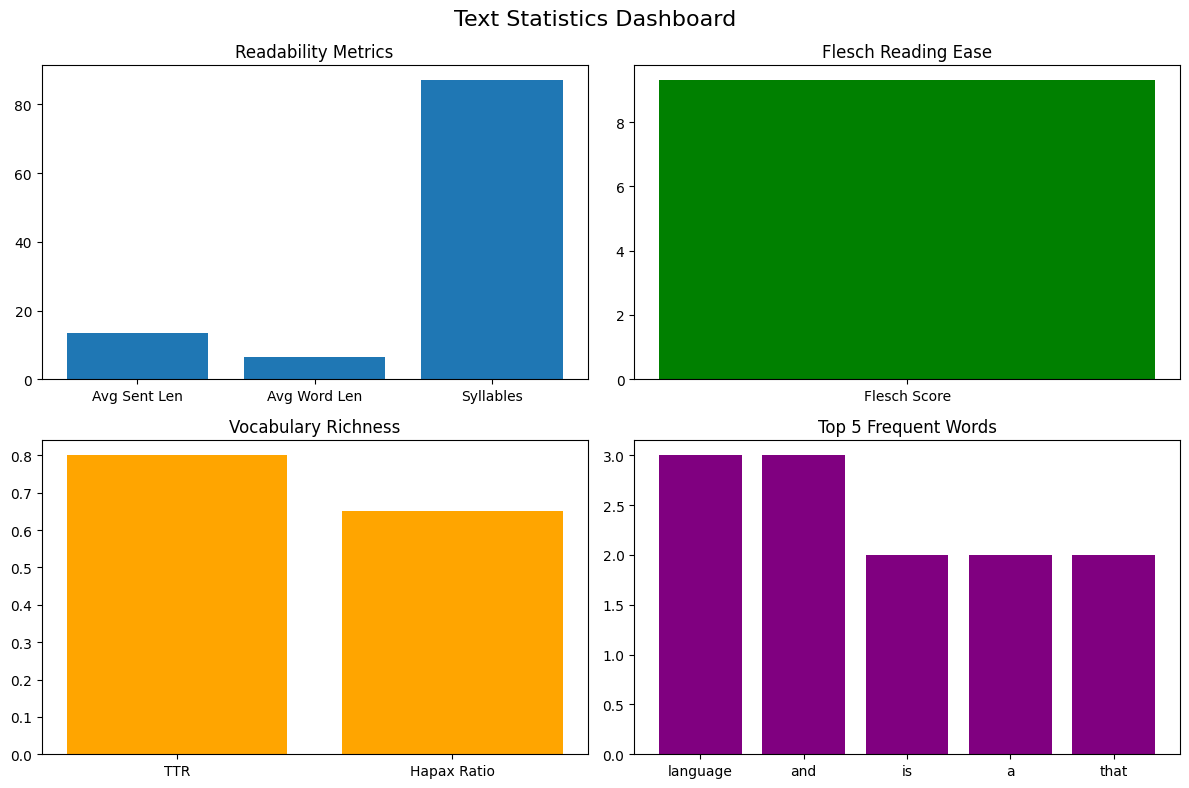

In [40]:
# TODO: Implement text statistics analyzer
import re
import string
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import cmudict
import nltk

# Ensure necessary NLTK data is downloaded
nltk.download('punkt', quiet=True)
nltk.download('cmudict', quiet=True)

class TextStatsAnalyzer:
    def __init__(self):
        self.syllable_dict = cmudict.dict()

    def count_syllables(self, word):
        word = word.lower()
        if word in self.syllable_dict:
            return max([len([y for y in x if y[-1].isdigit()]) for x in self.syllable_dict[word]])
        else:
            # Rough estimate: 1 syllable per vowel group
            return len(re.findall(r'[aeiouy]+', word.lower()))

    def calculate_readability(self, text):
        sentences = sent_tokenize(text)
        words = word_tokenize(text)
        words = [word for word in words if word.isalpha()]
        
        num_sentences = len(sentences)
        num_words = len(words)
        total_syllables = sum(self.count_syllables(word) for word in words)
        total_characters = sum(len(word) for word in words)

        avg_sentence_length = num_words / num_sentences if num_sentences else 0
        avg_word_length = total_characters / num_words if num_words else 0
        flesch_reading_ease = 206.835 - 1.015 * avg_sentence_length - 84.6 * (total_syllables / num_words) if num_words else 0

        return {
            "average_sentence_length": round(avg_sentence_length, 2),
            "average_word_length": round(avg_word_length, 2),
            "total_syllables": total_syllables,
            "flesch_reading_ease": round(flesch_reading_ease, 2)
        }

    def analyze_vocabulary(self, text):
        words = word_tokenize(text.lower())
        words = [word for word in words if word.isalpha()]

        total_words = len(words)
        unique_words = set(words)
        type_token_ratio = len(unique_words) / total_words if total_words else 0

        word_freq = Counter(words)
        hapax_legomena = [word for word, freq in word_freq.items() if freq == 1]
        hapax_ratio = len(hapax_legomena) / total_words if total_words else 0
        most_frequent = word_freq.most_common(5)

        return {
            "type_token_ratio": round(type_token_ratio, 3),
            "hapax_legomena_ratio": round(hapax_ratio, 3),
            "most_frequent_words": most_frequent
        }

    def create_dashboard(self, text):
        readability = self.calculate_readability(text)
        vocab = self.analyze_vocabulary(text)

        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle("Text Statistics Dashboard", fontsize=16)

        # Readability Metrics Bar Chart
        axs[0, 0].bar(["Avg Sent Len", "Avg Word Len", "Syllables"], 
                      [readability["average_sentence_length"], readability["average_word_length"], readability["total_syllables"]])
        axs[0, 0].set_title("Readability Metrics")

        # Flesch Score
        axs[0, 1].bar(["Flesch Score"], [readability["flesch_reading_ease"]], color="green")
        axs[0, 1].set_title("Flesch Reading Ease")

        # Vocabulary Richness
        axs[1, 0].bar(["TTR", "Hapax Ratio"], 
                      [vocab["type_token_ratio"], vocab["hapax_legomena_ratio"]], color="orange")
        axs[1, 0].set_title("Vocabulary Richness")

        # Most Frequent Words
        words, freqs = zip(*vocab["most_frequent_words"])
        axs[1, 1].bar(words, freqs, color="purple")
        axs[1, 1].set_title("Top 5 Frequent Words")

        plt.tight_layout()
        plt.show()

# Example usage:
if __name__ == "__main__":
    print("Challenge L3: Implement text statistics analyzer")
    sample_text = """
    Natural language processing is a field of artificial intelligence that focuses on the interaction between computers and human language.
    It involves understanding, interpreting, and generating human language in a way that is valuable.
    Applications include translation, sentiment analysis, and chatbots.
    """
    analyzer = TextStatsAnalyzer()
    print(analyzer.calculate_readability(sample_text))
    print(analyzer.analyze_vocabulary(sample_text))
    analyzer.create_dashboard(sample_text)


### Challenge 4: Multilingual Text Preprocessing

Extend preprocessing to handle multiple languages.

**Tasks:**
1. Implement language detection
2. Create language-specific preprocessing rules
3. Handle mixed-language texts
4. Support different alphabets and scripts

In [53]:
from langdetect import detect, DetectorFactory
from nltk.corpus import stopwords
import nltk
import re

# Ensure consistent language detection and download required resources
DetectorFactory.seed = 0
nltk.download('stopwords')

class MultilingualPreprocessor:
    def __init__(self):
        self.supported_languages = ['en', 'es', 'fr', 'de']
        try:
            from nltk.corpus import stopwords
            self.stopword_map = {
                lang: set(stopwords.words(lang))
                for lang in self.supported_languages
            }
        except:
            # Fallback stopwords
            self.stopword_map = {
                'en': {'the', 'is', 'and', 'this', 'in', 'it', 'to', 'a'},
                'es': {'el', 'la', 'los', 'es', 'y', 'en', 'un'},
                'fr': {'le', 'la', 'les', 'est', 'et', 'en', 'un'},
                'de': {'der', 'die', 'das', 'ist', 'und', 'ein'}
            }

    def detect_language(self, text):
        try:
            return detect(text)
        except:
            return 'unknown'

    def get_language_specific_stopwords(self, language):
        return self.stopword_map.get(language, set())

    def clean_text(self, text):
        return re.sub(r'[^\w\s]', '', text).lower()

    def preprocess_multilingual(self, text):
        lang = self.detect_language(text)
        if lang not in self.supported_languages:
            return text  # Skip preprocessing for unsupported languages

        stop_words = self.get_language_specific_stopwords(lang)
        words = self.clean_text(text).split()
        filtered = [word for word in words if word not in stop_words]
        return ' '.join(filtered)

    def handle_mixed_language(self, text):
        sentences = re.split(r'[.!?]', text)
        processed = [self.preprocess_multilingual(sentence.strip()) for sentence in sentences if sentence.strip()]
        return ' '.join(processed)

    def is_mixed_language(self, text):
        sentences = re.split(r'[.!?]', text)
        langs = {self.detect_language(sentence.strip()) for sentence in sentences if sentence.strip()}
        return len(langs) > 1

# --- Test with multilingual samples ---
multilingual_samples = [
    "Hello world, this is English text.",
    "Hola mundo, este es texto en español.",
    "Bonjour le monde, c'est du texte français.",
    "Hello, comment ça va? I'm mixing languages here."
]

print("Challenge M1: Implement multilingual preprocessing\n")

preprocessor = MultilingualPreprocessor()
for sample in multilingual_samples:
    print(f"\nOriginal: {sample}")
    if preprocessor.is_mixed_language(sample):
        processed = preprocessor.handle_mixed_language(sample)
        print(f"Processed (Mixed): {processed}")
    else:
        processed = preprocessor.preprocess_multilingual(sample)
        print(f"Processed: {processed}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/expansionislife/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Challenge M1: Implement multilingual preprocessing


Original: Hello world, this is English text.
Processed: hello world english text

Original: Hola mundo, este es texto en español.
Processed: hola mundo este texto español

Original: Bonjour le monde, c'est du texte français.
Processed: bonjour monde cest du texte français

Original: Hello, comment ça va? I'm mixing languages here.
Processed (Mixed): hello comment ça va im mixing languages here


### Challenge 5: Adaptive Preprocessing Pipeline

Create a pipeline that adapts based on text characteristics.

**Tasks:**
1. Analyze text characteristics automatically
2. Choose preprocessing steps based on analysis
3. Implement confidence scoring for decisions
4. Create adaptive configuration system

In [61]:
!pip3 install emoji
import re
import emoji
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download

# Download required NLTK resources
download('punkt')
download('stopwords')

class AdaptivePreprocessor:
    def __init__(self):
        self.text_analyzers = {
            'social_media': self._is_social_media,
            'formal': self._is_formal,
            'technical': self._is_technical,
            'conversational': self._is_conversational
        }

    def _is_social_media(self, text):
        score = 0
        score += len(re.findall(r"#\w+", text)) * 2  # hashtags
        score += len(re.findall(r"@\w+", text)) * 2  # mentions
        score += len([c for c in text if c in emoji.EMOJI_DATA]) * 2  # emojis
        score += len(re.findall(r"\blol\b|\bwtf\b|\bomg\b", text, re.IGNORECASE))
        return min(score / 10, 1.0)

    def _is_formal(self, text):
        words = word_tokenize(text)
        long_words = [w for w in words if len(w) > 6]
        punctuation_count = len(re.findall(r'[.!?]', text))
        stopword_count = len([w for w in words if w.lower() in stopwords.words('english')])
        score = (len(long_words) + punctuation_count + stopword_count / max(len(words), 1)) / 10
        return min(score, 1.0)

    def _is_technical(self, text):
        technical_keywords = ['API', 'SDK', 'compiler', 'runtime', 'algorithm', 'dataframe', 'function', 'variable']
        code_snippet = re.findall(r'`[^`]+`', text) or re.findall(r'```[\s\S]+?```', text)
        keyword_count = sum(1 for word in technical_keywords if word.lower() in text.lower())
        score = (len(code_snippet) * 2 + keyword_count) / 10
        return min(score, 1.0)

    def _is_conversational(self, text):
        contractions = re.findall(r"\b(?:n't|'re|'s|'m|'ll|'d|'ve)\b", text)
        informal = re.findall(r"\b(hi|hey|yo|dude|lol|ok|okay|yeah)\b", text, re.IGNORECASE)
        questions = text.count('?')
        score = (len(contractions) + len(informal) + questions) / 10
        return min(score, 1.0)

    def analyze_text_type(self, text):
        results = {}
        for label, analyzer in self.text_analyzers.items():
            results[label] = round(analyzer(text), 2)
        return results

    def get_adaptive_config(self, text):
        analysis = self.analyze_text_type(text)
        dominant = max(analysis, key=analysis.get)
        config = {
            'lowercase': True,
            'remove_stopwords': dominant in ['formal', 'technical'],
            'expand_contractions': dominant in ['conversational', 'social_media'],
            'preserve_emojis': dominant == 'social_media',
            'normalize_unicode': dominant in ['formal', 'technical'],
            'tokenize': True
        }
        return config

    def adaptive_preprocess(self, text):
        config = self.get_adaptive_config(text)
        print(f"[INFO] Using configuration for preprocessing: {config}")
        
        if config['lowercase']:
            text = text.lower()
        if config['expand_contractions']:
            text = re.sub(r"can't", "cannot", text)
            text = re.sub(r"n't", " not", text)
            text = re.sub(r"'re", " are", text)
            text = re.sub(r"'s", " is", text)
            text = re.sub(r"'ll", " will", text)
            text = re.sub(r"'m", " am", text)
            text = re.sub(r"'ve", " have", text)
        if config['normalize_unicode']:
            text = text.encode('ascii', 'ignore').decode()
        if not config['preserve_emojis']:
            text = ''.join(c for c in text if c not in emoji.EMOJI_DATA)
        if config['remove_stopwords']:
            words = word_tokenize(text)
            text = ' '.join(w for w in words if w.lower() not in stopwords.words('english'))
        if config['tokenize']:
            text = word_tokenize(text)
        return text

if __name__ == "__main__":
    preprocessor = AdaptivePreprocessor()

    sample_texts = [
        "OMG 😱 I can't believe this happened!! #shocked @friend",
        "The runtime complexity of this algorithm is O(n^2), and the implementation is shown below.",
        "Dear Sir, I am writing to express my interest in the internship position at your esteemed organization.",
        "hey! what's up? u coming 2 the party later or nah? lol"
    ]

    for idx, text in enumerate(sample_texts):
        print(f"\n--- Sample {idx + 1} ---")
        print("Original Text:", text)
        print("Text Type Analysis:", preprocessor.analyze_text_type(text))
        print("Adaptive Preprocessing Result:", preprocessor.adaptive_preprocess(text))

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 590 kB 2.9 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.

--- Sample 1 ---
Original Text: OMG 😱 I can't believe this happened!! #shocked @friend
Text Type Analysis: {'social_media': 0.7, 'formal': 0.51, 'technical': 0.0, 'conversational': 0.0}
[INFO] Using configuration for preprocessing: {'lowercase': True, 'remove_stopwords': False, 'expand_contractions': True, 'preserve_emojis': True, 'normalize_unicode': False, 'tokenize': True}
Adaptive Preprocessing Result: ['omg', '😱', 'i', 'can', 'not', 'believe', 'this', 'happened', '!', '!', '#', 'shocked', '@', 'friend']

--- Sample 2 ---
Original Text: The runtime complexity of this algorithm is O(n^2), and the implementation is shown below.
Text Type Analysis: {'social_media': 0.0, 'formal': 0.55, 'technical': 0.2, 'conversa

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/expansionislife/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/expansionislife/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Challenge 6: Preprocessing Quality Metrics

Develop metrics to evaluate preprocessing quality.

**Tasks:**
1. Create information preservation metrics
2. Measure noise reduction effectiveness
3. Evaluate consistency across similar texts
4. Build automated quality assessment

In [56]:
# TODO: Implement preprocessing quality metrics
class PreprocessingQualityEvaluator:
    def __init__(self):
        pass

    def information_preservation_score(self, original_text, processed_tokens):
        """
        Measure how much important information is preserved
        Consider: semantic content, named entities, key terms
        """
        # Your implementation here
        pass

    def noise_reduction_score(self, original_text, processed_tokens):
        """
        Measure effectiveness of noise removal
        Consider: removed URLs, mentions, special chars, etc.
        """
        # Your implementation here
        pass

    def consistency_score(self, similar_texts, preprocessing_func):
        """
        Measure consistency of preprocessing across similar texts
        """
        # Your implementation here
        pass

    def vocabulary_quality_score(self, processed_tokens):
        """
        Evaluate quality of resulting vocabulary
        Consider: diversity, meaningfulness, coverage
        """
        # Your implementation here
        pass

    def comprehensive_evaluation(self, original_texts, processed_texts):
        """
        Perform comprehensive quality evaluation
        """
        # Your implementation here
        pass

print("Challenge M3: Implement preprocessing quality metrics")

Challenge M3: Implement preprocessing quality metrics


### Challenge 7: Neural Preprocessing Pipeline

Implement neural network-based preprocessing components.

**Tasks:**
1. Train neural tokenizer using BPE or similar
2. Implement neural text normalization
3. Create learned text cleaning rules
4. Build end-to-end neural preprocessing

In [ ]:
# TODO: Implement neural preprocessing components
import torch
import torch.nn as nn

class NeuralTokenizer:
    def __init__(self, vocab_size=10000):
        """
        Implement BPE (Byte Pair Encoding) or similar neural tokenization
        """
        self.vocab_size = vocab_size
        self.vocab = {}
        self.merges = []

    def train(self, texts):
        """
        Train the tokenizer on a corpus
        """
        # Your implementation here
        pass

    def tokenize(self, text):
        """
        Tokenize text using learned BPE
        """
        # Your implementation here
        pass

class NeuralTextNormalizer(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=256):
        super().__init__()
        """
        Neural network for text normalization
        Can learn to normalize spelling, correct typos, etc.
        """
        # Your implementation here
        pass

    def forward(self, x):
        # Your implementation here
        pass

class LearnedTextCleaner:
    def __init__(self):
        """
        Learn text cleaning rules from data
        Use ML to identify what should be removed/kept
        """
        # Your implementation here
        pass

    def train_cleaning_rules(self, raw_texts, clean_texts):
        """
        Learn cleaning rules from examples
        """
        # Your implementation here
        pass

    def clean_text(self, text):
        """
        Apply learned cleaning rules
        """
        # Your implementation here
        pass

print("Challenge H1: Implement neural preprocessing pipeline")

### Challenge 8: Real-time Streaming Preprocessor

Build a system for real-time text preprocessing with memory constraints.

**Tasks:**
1. Implement streaming text processing
2. Handle memory-efficient operations
3. Create adaptive vocabulary management
4. Build incremental learning system

In [ ]:
# TODO: Implement real-time streaming preprocessor
from collections import deque
import threading
import queue

class StreamingPreprocessor:
    def __init__(self, max_memory_mb=100, buffer_size=1000):
        """
        Real-time text preprocessor with memory constraints
        """
        self.max_memory_mb = max_memory_mb
        self.buffer_size = buffer_size
        self.text_buffer = deque(maxlen=buffer_size)
        self.vocab = {}
        self.processing_queue = queue.Queue()

    def process_stream(self, text_stream):
        """
        Process streaming text data
        """
        # Your implementation here
        pass

    def update_vocabulary_incremental(self, new_tokens):
        """
        Update vocabulary incrementally with memory management
        """
        # Your implementation here
        pass

    def memory_efficient_preprocess(self, text):
        """
        Preprocess text with minimal memory usage
        """
        # Your implementation here
        pass

    def adaptive_vocab_pruning(self):
        """
        Prune vocabulary based on usage patterns
        """
        # Your implementation here
        pass

class IncrementalLearner:
    def __init__(self):
        """
        Learn preprocessing rules incrementally
        """
        # Your implementation here
        pass

    def update_model(self, new_data):
        """
        Update preprocessing model with new data
        """
        # Your implementation here
        pass

print("Challenge H2: Implement real-time streaming preprocessor")

### Challenge 9: Context-Aware Preprocessing

Create preprocessing that considers broader context and semantics.

**Tasks:**
1. Implement context-sensitive tokenization
2. Create semantic-aware text cleaning
3. Build discourse-level preprocessing
4. Develop cross-document consistency

In [ ]:
# TODO: Implement context-aware preprocessing
class ContextAwarePreprocessor:
    def __init__(self):
        """
        Preprocessing that considers semantic context
        """
        # Your implementation here
        pass

    def context_sensitive_tokenization(self, text, context_window=5):
        """
        Tokenize based on surrounding context
        Handle: compound words, phrasal verbs, named entities
        """
        # Your implementation here
        pass

    def semantic_text_cleaning(self, text):
        """
        Clean text while preserving semantic meaning
        Use NLP models to understand what's important
        """
        # Your implementation here
        pass

    def discourse_level_preprocessing(self, document):
        """
        Preprocess considering document structure
        Handle: coreference, discourse markers, topic coherence
        """
        # Your implementation here
        pass

    def cross_document_consistency(self, documents):
        """
        Ensure consistent preprocessing across related documents
        """
        # Your implementation here
        pass

class SemanticAnalyzer:
    def __init__(self):
        """
        Analyze semantic content for preprocessing decisions
        """
        # Your implementation here
        pass

    def identify_important_spans(self, text):
        """
        Identify semantically important text spans
        """
        # Your implementation here
        pass

    def measure_semantic_similarity(self, text1, text2):
        """
        Measure semantic similarity between texts
        """
        # Your implementation here
        pass

print("Challenge H3: Implement context-aware preprocessing")